In [8]:
#Importing Libraries
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
import seaborn as sns
from pathlib import Path


In [9]:
folder = Path ('C:/Upgrad Projects/ML1_M5_Clustering')               

In [10]:
#reading Dataset
retail = pd.read_csv(folder/"Online Retail.csv",  sep = ',',encoding = "ISO-8859-1", header= 0)
# parse date
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'], format = "%d-%m-%Y %H:%M")

In [11]:
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
retail.shape

(541909, 8)

In [12]:
retail.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

The data set is at the granularity of order level. So, it doesn’t make much sense to do missing value imputation because it would be very difficult to predict the individual missing details of individual orders. Hence, you have to remove the entries with the missing values.

In [14]:
#dropping the na cells
order_wise = retail.dropna()

In [16]:
order_wise.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

you need to transform this order-wise data into customer-wise data by finding key attributes that best characterises a customer. 
This is achieved through RFM analysis.

##### RFM analysis

In RFM analysis, you look at the recency, frequency and the monetary scores of all the customers for segmentation.

Recency: It measures how recently you visited the store or made a purchase

Frequency: It measures the frequency of the transactions the customers made

Monetary: It measures how much the customer spent on purchases he/she made

you will have one unique row corresponding to each customer.

In [78]:
#RFM implementation
amount  = pd.DataFrame(order_wise.Quantity * order_wise.UnitPrice, columns = ["Amount"])

#merging amount in order_wise
order_wise = pd.concat(objs = [order_wise, amount], axis = 1, ignore_index = False)

In [79]:
#Monetary Function
monetary = order_wise.groupby("CustomerID").Amount.sum()
monetary = monetary.reset_index()

In [80]:
monetary.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [81]:
#Frequency function
frequency = order_wise[['CustomerID', 'InvoiceNo']]

k = frequency.groupby("CustomerID").InvoiceNo.count()
k = k.reset_index()

In [82]:
k.columns = ["CustomerID", "Frequency"]

In [83]:
k.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [84]:
#creating master dataset
master = monetary.merge(k, on = "CustomerID", how = "inner")

In [86]:
master.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [17]:
#Generating recency function
# The latest “Invoice Date” forms the reference point 
# for the calculation of the “Recency” of each customer
recency  = order_wise[['CustomerID','InvoiceDate']].copy()
maximum = max(recency.InvoiceDate)

maximum


Timestamp('2011-12-09 12:50:00')

In [18]:
type(maximum)

pandas._libs.tslibs.timestamps.Timestamp

In [91]:
maximum = maximum + pd.DateOffset(days=1)
maximum

Timestamp('2011-12-10 12:50:00')

In [92]:
recency['diff'] = maximum - recency.InvoiceDate


In [94]:
recency.head()

,CustomerID,InvoiceDate,diff
0,17850.0,2010-12-01 08:26:00,374 days 04:24:00
1,17850.0,2010-12-01 08:26:00,374 days 04:24:00
2,17850.0,2010-12-01 08:26:00,374 days 04:24:00
3,17850.0,2010-12-01 08:26:00,374 days 04:24:00
4,17850.0,2010-12-01 08:26:00,374 days 04:24:00


For each order corresponding to each customer, you find the difference from the latest “Invoice Date” and then find the minimum “Recency” value for each customer.

In [96]:
#Dataframe merging by recency
df = pd.DataFrame(recency.groupby('CustomerID').diff.min())
df = df.reset_index()
df.columns = ["CustomerID", "Recency"]

In [97]:
df.head()

,CustomerID,Recency
0,12346.0,326 days 02:33:00
1,12347.0,2 days 20:58:00
2,12348.0,75 days 23:37:00
3,12349.0,19 days 02:59:00
4,12350.0,310 days 20:49:00


In [98]:
#Combining all recency, frequency and monetary parameters
RFM = k.merge(monetary, on = "CustomerID")
RFM = RFM.merge(df, on = "CustomerID")

In [99]:
RFM.head()

,CustomerID,Frequency,Amount,Recency
0,12346.0,2,0.00,326 days 02:33:00
1,12347.0,182,4310.00,2 days 20:58:00
2,12348.0,31,1797.24,75 days 23:37:00
3,12349.0,73,1757.55,19 days 02:59:00
4,12350.0,17,334.40,310 days 20:49:00


### Outlier Treatment

{'whiskers': [<matplotlib.lines.Line2D at 0x2afca6bc470>,
 'caps': [<matplotlib.lines.Line2D at 0x2afca6bcdd8>,
 'boxes': [<matplotlib.lines.Line2D at 0x2afca6bc2e8>],
 'medians': [<matplotlib.lines.Line2D at 0x2afc8176668>],
 'fliers': [<matplotlib.lines.Line2D at 0x2afc8176ac8>],
 'means': []}

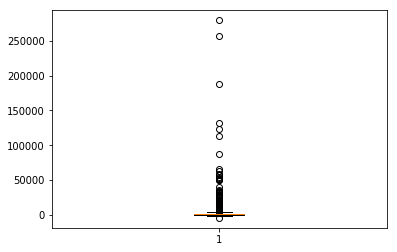

In [100]:
# outlier treatment for Amount
plt.boxplot(RFM.Amount)

In [101]:
Q1 = RFM.Amount.quantile(0.25)
Q3 = RFM.Amount.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Amount >= Q1 - 1.5*IQR) & (RFM.Amount <= Q3 + 1.5*IQR)]

{'whiskers': [<matplotlib.lines.Line2D at 0x2afc9d03fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x2afca4598d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2afc9d03eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x2afca461198>],
 'fliers': [<matplotlib.lines.Line2D at 0x2afca4615f8>],
 'means': []}

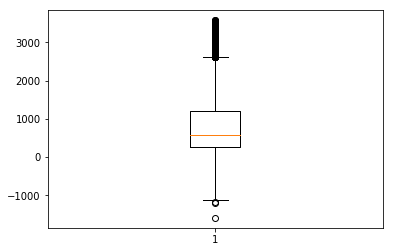

In [102]:
plt.boxplot(RFM.Amount)

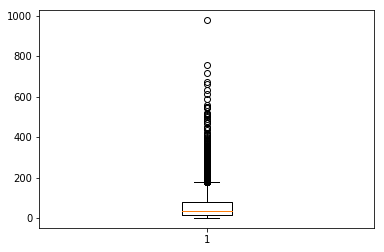

In [103]:
# outlier treatment for Frequency
plt.boxplot(RFM.Frequency)
Q1 = RFM.Frequency.quantile(0.25)
Q3 = RFM.Frequency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Frequency >= Q1 - 1.5*IQR) & (RFM.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
# outlier treatment for Recency
plt.boxplot(RFM.Recency)
Q1 = RFM.Recency.quantile(0.25)
Q3 = RFM.Recency.quantile(0.75)
IQR = Q3 - Q1
RFM = RFM[(RFM.Recency >= Q1 - 1.5*IQR) &
          (RFM.Recency <= Q3 + 1.5*IQR)]

##### Steps involved in data preparation:
1. Missing value treatment
2. Transforming data from Order-level to Customer-level
3. Calculation of RFM values
4. Outlier treatment
5. Standardisation of data

Scaling is important because:
Since the scales of the data are different, more weightage will be given to Monetary value. Data points which have very different monetary values will be classified differently, even though they might actually be very similar in Recency and Frequency.